In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython
import imageio
import os
import multiprocess as mp
from scipy.stats import maxwell

import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

import algorithms as a
import force_functions as f

In [2]:
np.random.seed(1)

In [3]:
t_max = 100
dt = .002
N = 64
lam = 0.1931833275037836

In [4]:
def init(N, L, lattice_constant):
    
    positions = list(np.arange(-L/2., L/2., lattice_constant))
    r0 = np.array(np.meshgrid(positions, positions, positions)).T.reshape(-1,3)
    p0 = maxwell.rvs(loc=0, scale=1.5, size=(N,3)) / np.sqrt(1.5)
    
    return r0, p0

In [5]:
r0, p0 = init(N=64, L=6., lattice_constant=1.5)

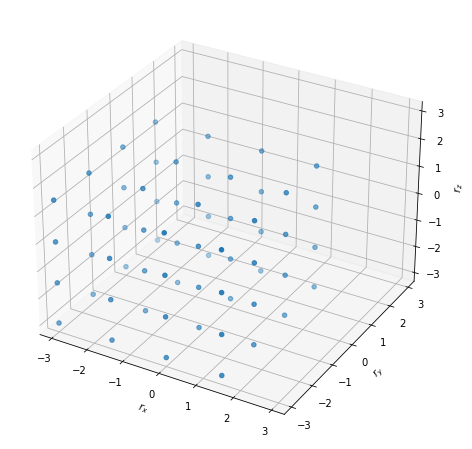

In [6]:
fig0 = plt.figure(figsize=(12,8));
ax0 = fig0.add_subplot(111, projection='3d')
ax0.scatter(r0[:,0], r0[:,1], r0[:,2])
ax0.set_xlabel(r'$r_x$')
ax0.set_ylabel(r'$r_y$')
ax0.set_zlabel(r'$r_z$')
ax0.set_xlim(-3.2,3.2)
ax0.set_ylim(-3.2,3.2)
ax0.set_zlim(-3.2,3.2)
#plt.savefig('./figures/init_pos.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
R, P, t = a.BABAB_Ndim(r0, p0, t_max, dt, f.LJ_force, lam, thermal_noise=False,
                       periodic={'PBC': True, 'box_size': 6., 'closed': False})

100%|██████████| 49999/49999 [2:13:30<00:00,  6.24it/s]  


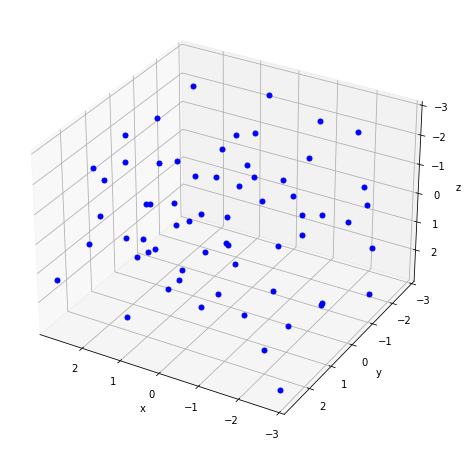

In [28]:
xlim = (R[:,:,0].max(), R[:,:,0].min())
ylim = (R[:,:,1].max(), R[:,:,1].min())
zlim = (R[:,:,2].max(), R[:,:,2].min())
files = []
for i in range(len(t)):
    
    if i%876==0:
        plt.clf()
        fig = plt.figure(figsize=(12,8));
        ax = fig.add_subplot(111, projection='3d')
        for part_i, part in enumerate(R[i]):
            ax.plot(part[0], part[1], part[2], color='blue', linestyle='', marker='o', markersize=5)
        
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_zlim(zlim)
        
        filename = f'./figures/frame_{int(i/876)}.png'
        plt.savefig(filename)
        files.append(filename)
        
        plt.draw()
        IPython.display.clear_output(wait=True)
        IPython.display.display(fig)
    plt.close()
IPython.display.clear_output(wait=True)

In [29]:
with imageio.get_writer('./figures/3d_trajectory.gif', mode='I', fps=5) as writer:
    for file in files:
        image = imageio.imread(file)
        os.remove(file)
        writer.append_data(image)

In [11]:
r0, p0 = init(N=64, L=6., lattice_constant=1.5)

R_2dt, P_2dt, t_2dt = a.velocity_verlet_Ndim(r0, p0, t_max, 2*dt, f.LJ_force, 
                                             periodic={'PBC': True, 'box_size': 6., 'closed': True})

100%|██████████| 24999/24999 [45:22<00:00,  9.18it/s] 


In [22]:
def calc_energy(r, p, sigma=1):
    
    # V = np.zeros(r.shape[0])
    V = 0
    #for i in range(len(r)):
    #    for j in range(len(r)):
    #        if i <= j:
    #            continue
    #        else:
    #            d = r[i] - r[j]
    #            d_mag = np.linalg.norm(d)
    #
    #            V += (4 * np.power(sigma / d_mag, 12) - 4 * np.power(sigma / d_mag, 6))
    
    for i, r_i in enumerate(r):
        d = np.delete(r, np.arange(i+1), axis=0) - r_i
        d_mag = np.linalg.norm(d, axis=1)
    
        V += (4 * np.power(sigma / d_mag, 12) - 4 * np.power(sigma / d_mag, 6)).sum()
    
    T = (np.linalg.norm(p, axis=1)**2 / 2.).sum()
    
    return V + T

In [23]:
E = np.zeros(len(t))
for i in tqdm(range(len(t))):
    E[i] = calc_energy(R[i], P[i])

100%|██████████| 50000/50000 [01:25<00:00, 586.74it/s]


In [24]:
E_2dt = np.zeros(len(t_2dt))
for i in tqdm(range(len(t_2dt))):
    E_2dt[i] = calc_energy(R_2dt[i], P_2dt[i])

100%|██████████| 25000/25000 [00:43<00:00, 574.85it/s]


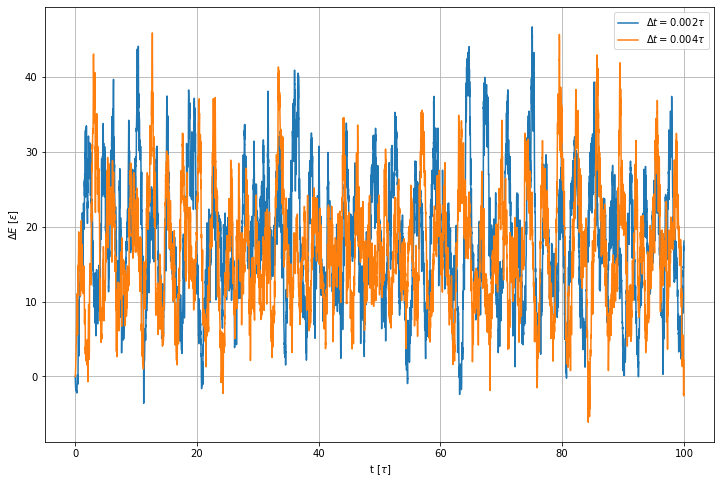

In [26]:
fig1, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(t, E-E[0], label=r'$\Delta t=0.002\tau$')
#ax1.plot(t[np.where(t<1.)], E[np.where(t<1.)], label=r'$\Delta t=0.002\tau$')
ax1.plot(t_2dt, E_2dt-E_2dt[0], label=r'$\Delta t=0.004\tau$')
ax1.set_xlabel(r't $[\tau]$')
ax1.set_ylabel(r'$\Delta E$ $[\epsilon]$')
ax1.legend()
ax1.grid(True)
plt.savefig('./figures/energy.png', dpi=300, bbox_inches='tight')
plt.show()

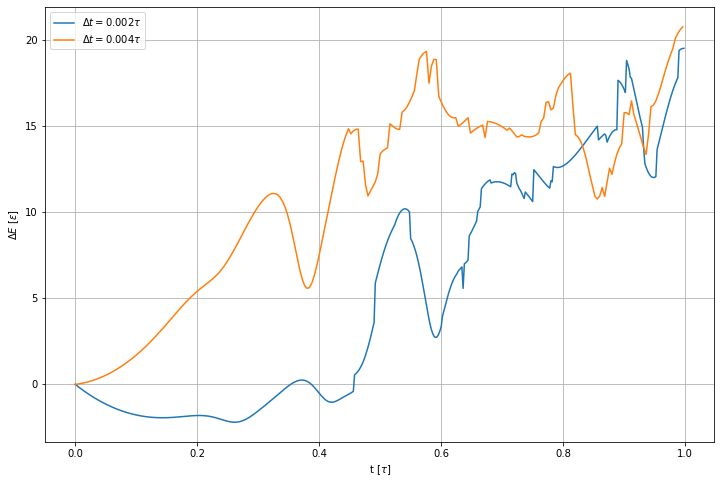

In [27]:
fig2, ax2 = plt.subplots(figsize=(12,8))
ax2.plot(t[np.where(t<1)], E[np.where(t<1)]-E[0], label=r'$\Delta t=0.002\tau$')
ax2.plot(t_2dt[np.where(t_2dt<1)], E_2dt[np.where(t_2dt<1)]-E_2dt[0], label=r'$\Delta t=0.004\tau$')
ax2.set_xlabel(r't $[\tau]$')
ax2.set_ylabel(r'$\Delta E$ $[\epsilon]$')
ax2.legend()
ax2.grid(True)
plt.savefig('./figures/energy_ini.png', dpi=300, bbox_inches='tight')
plt.show()